## Handle Imports

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Concatenate, Dropout

import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import pydicom
import glob
import os

## Config Variables

In [3]:
BASE_IMG_DIR = "data/"

EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 192
LR = 1e-3

RANDOM_SEED = 42

TEST_SPLIT = 0.2

In [4]:
def info(msg):
    print(f"[INFO] {msg}\n")
    
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0.0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [5]:
df = pd.read_excel("Stroke _DCM _Train_Labels.xlsx")

## Remove unneeded rows and rename columns

In [6]:
# Drop second row and last row
df.drop(index=df.index[-1], axis=0, inplace=True)
df.drop(index=df.index[0], axis=0, inplace=True)

In [7]:
df.rename(columns = {'SERIES': "Positive", "Unnamed: 4": "TP", "Unnamed: 5": "Negative"}, inplace = True)

In [8]:
df.head()

,ID,IMAGE NAME,IMAGE COUNT,Positive,TP,Negative
1,1,STP21,50.0,26 to 44,19,31
2,2,STP22,50.0,26 to 46,21,29
3,3,STP23,50.0,26 to 42,17,33
4,4,STP24,50.0,26 to 46,21,29
5,5,STP25,50.0,26 to 45,20,30


## Create functions to generate image ranges for the data frame

In [9]:
def resolve_to_range(txt):
    txt = txt.split(",")
    _l = []
    
    for i in txt:
        a, b = [int(v) for v in i.split("to")]
        
        for j in range(a, b+1):
            _l.append(j)
            
    return _l

## Convert Positive column to have individual positive numbers

In [10]:
df.Positive = df.Positive.apply(resolve_to_range)
df.head()

,ID,IMAGE NAME,IMAGE COUNT,Positive,TP,Negative
1,1,STP21,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",19,31
2,2,STP22,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",21,29
3,3,STP23,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",17,33
4,4,STP24,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",21,29
5,5,STP25,50.0,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...",20,30


## Create new DataFrame holding the ImageWise Data

In [11]:
dataset = {"Images": [], "Tumour": []}

for i in range(1, df.shape[0]+1):
    fn = df["IMAGE NAME"][i]
    pos_l = df.Positive[i]
    
    files = os.listdir(BASE_IMG_DIR + fn)
    files.remove("studyXml.xml")
    
    for index, f in enumerate(files):
        dataset["Images"].append(f"{BASE_IMG_DIR}{fn}/{f}")
        if index+1 in pos_l:
            dataset["Tumour"].append(1)
        else:
            dataset["Tumour"].append(0)

info("Total No. of Positive Samples: " + str(dataset["Tumour"].count(1)))
info("Total No. of Negative Samples: " + str(dataset["Tumour"].count(0)))

class_weights = {0: 1.0, 1: 3192/2108}
print(class_weights)

[INFO] Total No. of Positive Samples: 2108

[INFO] Total No. of Negative Samples: 3192

{0: 1.0, 1: 1.5142314990512333}


## Load the cleaned data into a new DataFrame

In [12]:
data_df = pd.DataFrame(dataset)
data_df.head()

,Images,Tumour
0,data/STP21/1.3.6.1.4.1.25403.52231602114.14040...,0
1,data/STP21/1.3.6.1.4.1.25403.52231602114.14040...,0
2,data/STP21/1.3.6.1.4.1.25403.52231602114.14040...,0
3,data/STP21/1.3.6.1.4.1.25403.52231602114.14040...,0
4,data/STP21/1.3.6.1.4.1.25403.52231602114.14040...,0


## Load the images and convert them into a Numpy array

In [13]:
image_data = []
target = np.array(data_df.Tumour)

In [14]:
for fn in data_df.Images:
    image = pydicom.read_file(fn).pixel_array
    
    # Normalise the Image values between 0.0 and 1.0
    image = image - np.min(image)
    image = image / np.max(image)
    image = image.reshape(image.shape[0], image.shape[1], 1)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    image_data.append(image)
    
image_data = np.array(image_data)

## Plot random images

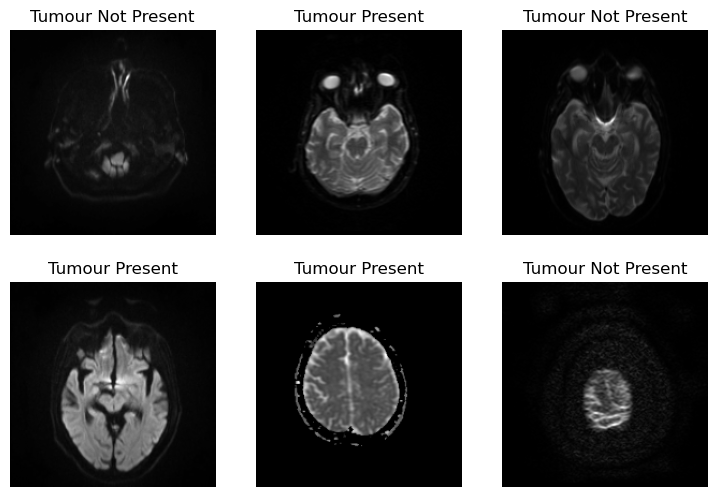

In [15]:
random_indexes = random.sample(range(len(image_data)), k=6)

fig, axs = plt.subplots(2, 3, figsize=(9, 6))

for (idx, c_ax) in zip(random_indexes, axs.flatten()):
    c_ax.imshow(image_data[idx], cmap="gray")
    if target[idx] == 1:
        title = "Tumour Present"
    else:
        title = "Tumour Not Present"
    c_ax.set_title(title)
    c_ax.axis("off")

In [16]:
X_train, X_test, y_train, y_test = train_test_split(image_data, target,
                                                    test_size=TEST_SPLIT,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True,
                                                    stratify=target)

## Create Data Augumentation

In [17]:
train_aug = ImageDataGenerator(rotation_range=10,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

test_aug = ImageDataGenerator()

train_gen = train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE)
test_gen = test_aug.flow(X_test, y_test, batch_size=BATCH_SIZE)

training_steps_per_epoch = train_gen.n // BATCH_SIZE
test_steps_per_epoch = test_gen.n // BATCH_SIZE

info(f"Training Steps per Epoch: {training_steps_per_epoch}")
info(f"Test Steps per Epoch: {test_steps_per_epoch}")

[INFO] Training Steps per Epoch: 132

[INFO] Test Steps per Epoch: 33



## Initialise the model

In [18]:
resnet_model = tf.keras.applications.resnet_v2.ResNet101V2(weights=None,
                                                           include_top=False,
                                                           input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 1)))

flatten = resnet_model.output
flatten = Flatten()(flatten)
dense = Dense(128, activation="relu")(flatten)
dropout = Dropout(0.2)(dense)
dense = Dense(64, activation="relu")(dropout)
dropout = Dropout(0.2)(dense)
dense = Dense(32, activation="relu")(dropout)
dropout = Dropout(0.2)(dense)
dense = Dense(32, activation="relu")(dropout)
dropout = Dropout(0.2)(dense)
dense = Dense(16, activation="relu")(dropout)
prediction_layer = Dense(1, activation="sigmoid")(dense)
model = Model(inputs=resnet_model.input, outputs=prediction_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 98, 98, 64)   0           ['conv1_conv[0][0]']         

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              metrics=[f1_score, "accuracy"],
              loss="binary_crossentropy")

In [21]:
save_best = tf.keras.callbacks.ModelCheckpoint(f"model_brainstroke.h5",
                                               monitor="val_loss",
                                               mode="min",
                                               save_best_only=True,
                                               verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="min",
                                                 patience=10)

In [23]:
history = model.fit(train_gen,
          steps_per_epoch=training_steps_per_epoch,
          validation_data=test_gen,
          validation_steps=test_steps_per_epoch,
          epochs=EPOCHS,
          class_weight=class_weights,
          callbacks=[save_best, early_stopping])

Epoch 1/50
116/132 [=========================>....] - ETA: 2:43 - loss: 1.2193 - f1_score: 0.4351 - accuracy: 0.5030

In [ ]:
model = tf.keras.models.load_model("model_brainstroke_inception.h5", compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              metrics=[f1_score, "accuracy"],
              loss="binary_crossentropy")

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train vs test Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training Loss", "Test Loss"], loc="upper right")
plt.show()

In [ ]:
pred = model.predict(test_gen, verbose=1)
pred